In [1]:
import numpy as np
import pandas as pd
from pandas import Series
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
sns.set(font_scale=2.5)

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
encodings = []
def number_encoding(df, list_col, print_map=True):
    global encodings
    for col in list_col:
        dict_map = {}
        i = 0
        for idx in sorted(df[col].unique()):
            dict_map[idx] = i
            i += 1
        df[col] = df[col].map(dict_map)
        
        if print_map:
            print(dict_map)
        encodings += [dict_map]
        
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

In [2]:
train['Family'] = train['SibSp'] + train['Parch'] + 1
test['Family'] = test['SibSp'] + test['Parch'] + 1

test.loc[test.Fare.isnull(), 'Fare'] = test['Fare'].mean()
train.loc[train.Fare.isnull(), 'Fare'] = train['Fare'].mean()

train['Fare'] = train['Fare'].map(lambda x: np.log(x) if x > 0 else 0)
test['Fare'] = test['Fare'].map(lambda x: np.log(x) if x > 0 else 0)

In [3]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,2.057860,NaN,Q,1
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,1.945910,NaN,S,2
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,2.270836,NaN,Q,1
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,2.159003,NaN,S,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,2.508582,NaN,S,3


## Filling null

### Filling age

In [4]:
train['Initial'] = train.Name.str.extract('([A-Za-z]+)\.')
display(train['Initial'].head())
test['Initial'] = train.Name.str.extract('([A-Za-z]+)\.')
display(test['Initial'].head())

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Initial, dtype: object

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Initial, dtype: object

In [5]:
pd.crosstab(train['Initial'], train['Sex']).T.style.background_gradient(cmap='summer_r')

Initial,Capt,Col,Countess,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Sex,,,,,,,,,,,,,,,,,
female,0,0,1,0,1,0,1,0,0,182,2,1,0,125,1,0,0
male,1,2,0,1,6,1,0,2,40,0,0,0,517,0,0,6,1


In [6]:
train['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don', 'Dona'],
                        ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr', 'Mr'],inplace=True)

test['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don', 'Dona'],
                        ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr', 'Mr'],inplace=True)

In [7]:
train[['Age', 'Initial']].groupby('Initial').mean()

,Age
Initial,
Master,4.574167
Miss,21.860000
Mr,32.739609
Mrs,35.981818
Other,45.888889


In [8]:
train.loc[train.Age.isnull() & (train.Initial == 'Mr'), 'Age'] = 32.7
train.loc[train.Age.isnull() & (train.Initial == 'Miss'), 'Age'] = 21.9
train.loc[train.Age.isnull() & (train.Initial == 'Master'), 'Age'] = 4.5
train.loc[train.Age.isnull() & (train.Initial == 'Mrs'), 'Age'] = 36.0
train.loc[train.Age.isnull() & (train.Initial == 'Other'), "Age"] = 45.9

test.loc[test.Age.isnull() & (test.Initial == 'Mr'), 'Age'] = 32.7
test.loc[test.Age.isnull() & (test.Initial == 'Miss'), 'Age'] = 21.9
test.loc[test.Age.isnull() & (test.Initial == 'Master'), 'Age'] = 4.5
test.loc[test.Age.isnull() & (test.Initial == 'Mrs'), 'Age'] = 36.0
test.loc[test.Age.isnull() & (test.Initial == 'Other'), "Age"] = 45.9

### Filling embarked

In [9]:
train['Embarked'].isnull().sum()
#Just fill it S

2

In [10]:
train['Embarked'].fillna('S', inplace=True)
test['Embarked'].fillna('S', inplace=True)
train['Embarked'].isnull().sum()
#Just fill it S

0

## String to numerical

In [11]:
train.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family,Initial
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,1.981001,NaN,S,2,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,4.266662,C85,C,2,Mrs


In [12]:
number_encoding(train, ['Sex', 'Initial', 'Embarked'])
number_encoding(test, ['Sex', 'Initial', 'Embarked'])

{'female': 0, 'male': 1}
{'Master': 0, 'Miss': 1, 'Mr': 2, 'Mrs': 3, 'Other': 4}
{'C': 0, 'Q': 1, 'S': 2}
{'female': 0, 'male': 1}
{'Master': 0, 'Miss': 1, 'Mr': 2, 'Mrs': 3, 'Other': 4}
{'C': 0, 'Q': 1, 'S': 2}


In [13]:
train.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family,Initial
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,1.981001,NaN,2,2,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,4.266662,C85,0,2,3


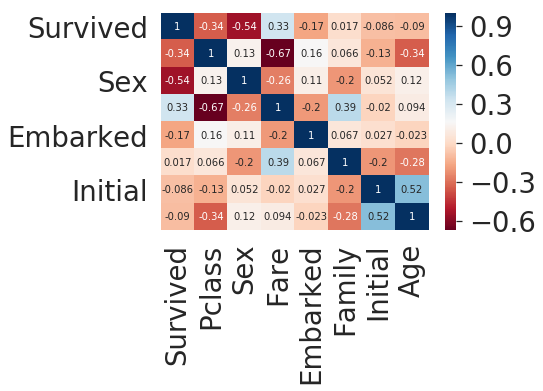

In [14]:
heatmap = train[['Survived', 'Pclass', 'Sex', 'Fare', 'Embarked', 'Family', 'Initial', 'Age']]
sns.heatmap(heatmap.astype(float).corr(), cmap=plt.cm.RdBu, annot=True)

### Dropping Columns

In [15]:
train.drop(['PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket', 'Cabin'], axis=1, inplace=True)
test.drop(['PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket', 'Cabin'], axis=1, inplace=True)

In [16]:
train.head(2)

,Survived,Pclass,Sex,Age,Fare,Embarked,Family,Initial
0,0,3,1,22.0,1.981001,2,2,2
1,1,1,0,38.0,4.266662,0,2,3


## Building model

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data_utils
from torchvision import transforms

### Datasets

In [18]:
train_X = train
train_Y = tmp_Y = train['Survived'].values
#died = [0, 1]
#survived = [1, 0]
is_died = lambda x: [1, 0] if x == 1 else [0, 1]
train_Y = [is_died(i) for i in tmp_Y]
del train['Survived']

In [20]:
train_X = torch.tensor(train_X.values).float()
train_Y = torch.tensor(train_Y).long()

RuntimeError: Could not infer dtype of builtin_function_or_method

In [21]:
print(type(train_X), type(train_Y))

<class 'torch.Tensor'> <class 'torch.Tensor'>


### Model

In [22]:
class Died(nn.Module):
    def __init__(self):
        super(Died, self).__init__()
        self.linear = nn.Linear(7, 2) #7 : input, 2 : output (died or survived)
        
    def forward(self, x):
        return (self.linear(x))
    
died = Died()
died

Died(
  (linear): Linear(in_features=7, out_features=2, bias=True)
)

In [23]:
train_set = data_utils.TensorDataset(train_X, train_Y)
train_loader = data_utils.DataLoader(train_set, batch_size = 64, shuffle = True)

In [31]:
optimizer = optim.Adam(died.parameters(), lr=0.01)
get_loss = nn.CrossEntropyLoss()
loss_graph = []

In [34]:
from torch.autograd import Variable
num_epoch = 10
for epoch in range(num_epoch):
    for x, y in train_loader:
        
        x = Variable(x)
        y = Variable(y)
        optimizer.zero_grad()
        out = died(x)
        loss = get_loss(x, torch.max(y, 1)[1])
        loss.backward()
        optimizer.step()
        loss_graph.append(loss.data)

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

Last Loss Value : 32.214420318603516


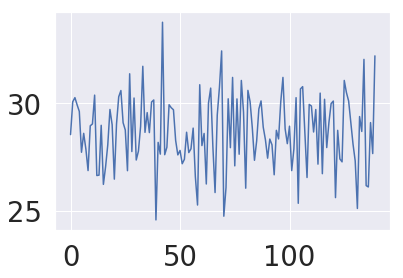

In [33]:
plt.plot(loss_graph)
print('Last Loss Value : {}'.format(loss_graph[-1]))

## Accuracy

In [ ]:
# Test the Model
correct = 0
total = 0
for x, y in train_loader:
    x = out
    outputs = model(images)
    _, predicted = torch.max(out.data, 1)
    total += train_X.size(0)
    correct += (predicted == labels).sum()